In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:
# Load the AnnData object from the .h5ad file
adata = sc.read("PBMC_combined_annotated_3data.h5ad")
adata = adata[adata.obs['source'] == 'SSTX'].copy() ##Only use TotalX data


1. Compute AA demand

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import gzip
from collections import Counter, defaultdict
from Bio import SeqIO

# Step 1: Load protein sequences from GENCODE
fasta_path = "gencode.v47.pc_translations.fa.gz"
gene_to_protein = {}

with gzip.open(fasta_path, "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        header = record.description
        fields = header.split('|')
        if len(fields) >= 7:
            gene_symbol = fields[6]
            if gene_symbol not in gene_to_protein:
                gene_to_protein[gene_symbol] = str(record.seq)

# Step 2: Amino acid counter
def count_amino_acids(seq):
    aa_counts = Counter(seq.upper())
    standard_aa = "ACDEFGHIKLMNPQRSTVWYUX"
    return {aa: aa_counts.get(aa, 0) for aa in standard_aa}

# Step 3: Prepare adata variables
cell_types = adata.obs["cell_type_lvl2"]
counts_matrix = adata.layers["counts"]
gene_names = adata.var_names
cell_type_groups = cell_types.unique()

# Step 4: Sum expression across cell types
aa_demand = defaultdict(lambda: defaultdict(float))  # [aa][cell_type] = demand

for cell_type in cell_type_groups:
    cell_mask = (cell_types == cell_type).values
    gene_sums = counts_matrix[cell_mask, :].sum(axis=0).A1 if hasattr(counts_matrix, "A1") else counts_matrix[cell_mask, :].sum(axis=0)
    for gene, umi_count in zip(gene_names, np.ravel(gene_sums)):
        if umi_count > 0 and gene in gene_to_protein:
            aa_counts = count_amino_acids(gene_to_protein[gene])
            for aa, count in aa_counts.items():
                aa_demand[aa][cell_type] += count * umi_count

# Step 5: Convert to DataFrame
df_demand = pd.DataFrame(aa_demand).fillna(0).astype(int).T  # rows = AA, cols = cell types
df_demand.to_csv("tRNA_demand_per_amino_acid_per_cell_type.csv")

# Optional: Display top AAs per cell type
print(df_demand.head(10))


   CD14+ Mono    T Naive  CD16+ Mono     CD4+ T     CD8+ T    NK Cell  \
A   920395979  172151762   166924110  291533422   94546091   95141325   
C   262898574   48799665    46378473   79728392   25892162   26756308   
D   674296300  126294681   120155619  210320382   68502054   70379140   
E   977301876  184954993   174263312  307667104  100355115  102923780   
F   464998033   86629860    83289375  144739158   47278406   48238938   
G   842814784  158870185   151068498  267289462   86052403   86489570   
H   339059282   64602396    59980443  106418553   34771209   35389512   
I   601611704  116014361   107412147  193746487   62112090   62930483   
K   865063965  174636915   155597638  293159168   92111324   91504210   
L  1271625925  236277157   229013390  394122820  129758249  133218592   

     B Naive       pDC  B Memory  Basophil  Platelet      cDC2       NKT  \
A   79910778  10749968  37004697   8174465   1390535  42344086  15351225   
C   22270941   2882496  10068402   2355340  

2. Compute tRNA availability

In [5]:
# Extract amino acid part from tRNA names
import pandas as pd

# Filter only tRNA genes
tRNA_mask = adata.var_names.str.contains("tRNA", case=False, regex=True)
tRNA_genes = adata.var_names[tRNA_mask]

# Extract the part before "_tRNA-"
aa_names = tRNA_genes.str.extract(r"^(.+?)_tRNA(?:-\d+)?")[0]

# Get unique amino acid codes
unique_aa_names = sorted(aa_names.dropna().unique())
print("Unique tRNA amino acid labels in dataset:")
print(unique_aa_names)

Unique tRNA amino acid labels in dataset:
['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'SeC', 'SeC(e)', 'Ser', 'Sup', 'Thr', 'Trp', 'Tyr', 'Undet', 'Val']


In [6]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Setup
counts_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
cell_types = adata.obs["cell_type_lvl2"]
cell_type_groups = cell_types.unique()

# Identify tRNA genes and their amino acids
tRNA_mask = adata.var_names.str.contains("tRNA")
tRNA_genes = adata.var_names[tRNA_mask]
amino_acids = tRNA_genes.str.extract(r"^(.+?)_tRNA(?:-\d+)?$")[0].values
# Subset expression matrix to tRNA genes
tRNA_expr = counts_matrix[:, tRNA_mask]

# Initialize supply table
aa_trna_supply = defaultdict(lambda: defaultdict(float))

# Compute supply per amino acid per cell type
for cell_type in cell_type_groups:
    mask = (cell_types == cell_type).values
    expr_sum = tRNA_expr[mask, :].sum(axis=0)
    expr_sum = np.array(expr_sum).ravel()  # ensures it's a 1D array of scalars


    for aa, value in zip(amino_acids, expr_sum):
        if value > 0:
            aa_trna_supply[aa][cell_type] += value

# Convert to DataFrame
df_trna_aa_supply = pd.DataFrame(aa_trna_supply).fillna(0).T
df_trna_aa_supply.index.name = "amino_acid"
df_trna_aa_supply.columns.name = "cell_type"

# Show the result
display(df_trna_aa_supply.head())


cell_type,CD14+ Mono,T Naive,CD16+ Mono,CD4+ T,CD8+ T,NK Cell,B Naive,pDC,B Memory,Basophil,Platelet,cDC2,NKT,Plasmablast,Proerythroblast
amino_acid,,,,,,,,,,,,,,,
Asn,1440.0,1402.0,323.0,2290.0,617.0,740.0,1525.0,57.0,778.0,37.0,5.0,162.0,68.0,27.0,17.0
Gly,116405.0,44066.0,29147.0,77756.0,28333.0,29631.0,20857.0,2301.0,12270.0,2328.0,1897.0,5601.0,3935.0,1065.0,472.0
Lys,19512.0,8002.0,4194.0,13968.0,4715.0,5881.0,5119.0,722.0,2442.0,302.0,164.0,1150.0,649.0,172.0,64.0
Cys,3529.0,975.0,690.0,1605.0,547.0,662.0,1384.0,93.0,914.0,26.0,5.0,189.0,56.0,19.0,7.0
His,746.0,337.0,195.0,484.0,123.0,146.0,283.0,23.0,169.0,10.0,5.0,37.0,8.0,6.0,3.0


In [7]:
df_trna_aa_supply

cell_type,CD14+ Mono,T Naive,CD16+ Mono,CD4+ T,CD8+ T,NK Cell,B Naive,pDC,B Memory,Basophil,Platelet,cDC2,NKT,Plasmablast,Proerythroblast
amino_acid,,,,,,,,,,,,,,,
Asn,1440.0,1402.0,323.0,2290.0,617.0,740.0,1525.0,57.0,778.0,37.0,5.0,162.0,68.0,27.0,17.0
Gly,116405.0,44066.0,29147.0,77756.0,28333.0,29631.0,20857.0,2301.0,12270.0,2328.0,1897.0,5601.0,3935.0,1065.0,472.0
Lys,19512.0,8002.0,4194.0,13968.0,4715.0,5881.0,5119.0,722.0,2442.0,302.0,164.0,1150.0,649.0,172.0,64.0
Cys,3529.0,975.0,690.0,1605.0,547.0,662.0,1384.0,93.0,914.0,26.0,5.0,189.0,56.0,19.0,7.0
His,746.0,337.0,195.0,484.0,123.0,146.0,283.0,23.0,169.0,10.0,5.0,37.0,8.0,6.0,3.0
Gln,7003.0,3198.0,1713.0,5770.0,2041.0,1960.0,1654.0,132.0,862.0,151.0,146.0,287.0,287.0,92.0,23.0
Val,20207.0,5367.0,4526.0,9748.0,3238.0,3604.0,4643.0,461.0,2770.0,165.0,135.0,1053.0,383.0,267.0,55.0
Glu,35899.0,12281.0,10716.0,22788.0,7280.0,8819.0,7173.0,751.0,3889.0,582.0,372.0,2174.0,947.0,241.0,151.0
Met,2938.0,1577.0,744.0,2676.0,1029.0,1034.0,1111.0,111.0,582.0,106.0,27.0,181.0,108.0,49.0,17.0


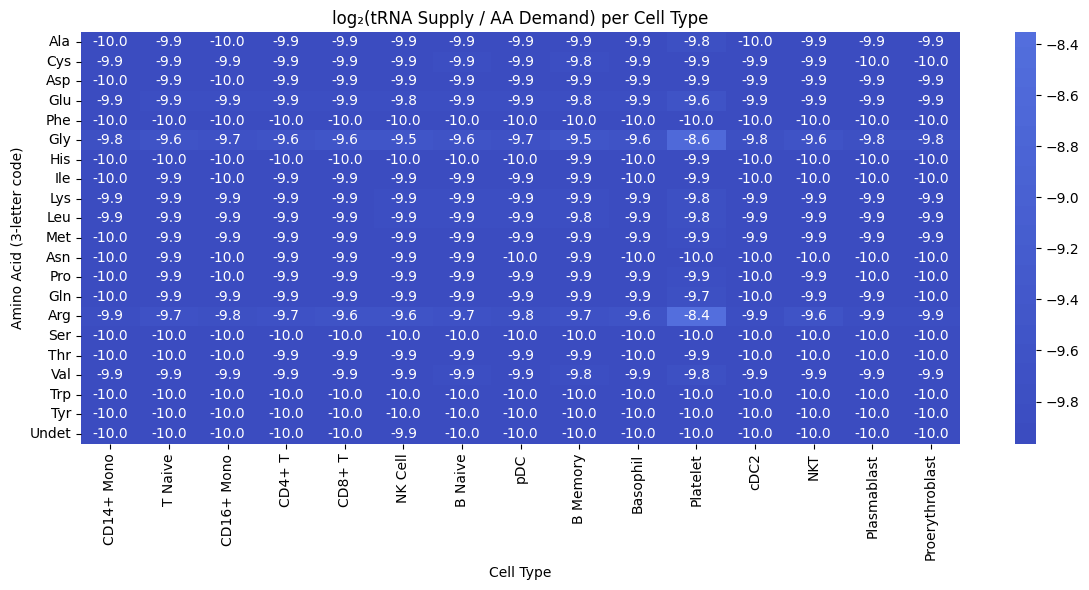

In [8]:
# Standard 1-letter to 3-letter amino acid mapping
aa1_to_aa3 = {
    'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp',
    'C': 'Cys', 'Q': 'Gln', 'E': 'Glu', 'G': 'Gly',
    'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys',
    'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser',
    'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val',
    'U': 'Sec',       # Selenocysteine
    '*': 'Stop',      # Optional: stop codon
    'X': 'Undet'      # Optional: unknown/ambiguous
}

# Rename demand index from 1-letter to 3-letter
df_demand_named = df_demand.rename(index=aa1_to_aa3)

# Apply optional cleaning to tRNA amino acid names
df_trna_aa_supply_clean = df_trna_aa_supply.copy()
df_trna_aa_supply_clean.index = df_trna_aa_supply_clean.index.str.replace(r'SeC\(e\)', 'Sec', regex=True)
df_trna_aa_supply_clean.index = df_trna_aa_supply_clean.index.str.replace(r'Undet', 'Undet')


shared_aas = df_demand_named.index.intersection(df_trna_aa_supply.index)
demand = df_demand_named.loc[shared_aas]
supply = df_trna_aa_supply.loc[shared_aas]

# Compute ratio and log transform
ratio = supply / (demand + 1e-6)
log_ratio = np.log2(ratio + 1e-3)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(log_ratio, cmap="coolwarm", center=0, annot=True, fmt=".1f")
plt.title("log₂(tRNA Supply / AA Demand) per Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("Amino Acid (3-letter code)")
plt.tight_layout()
plt.show()


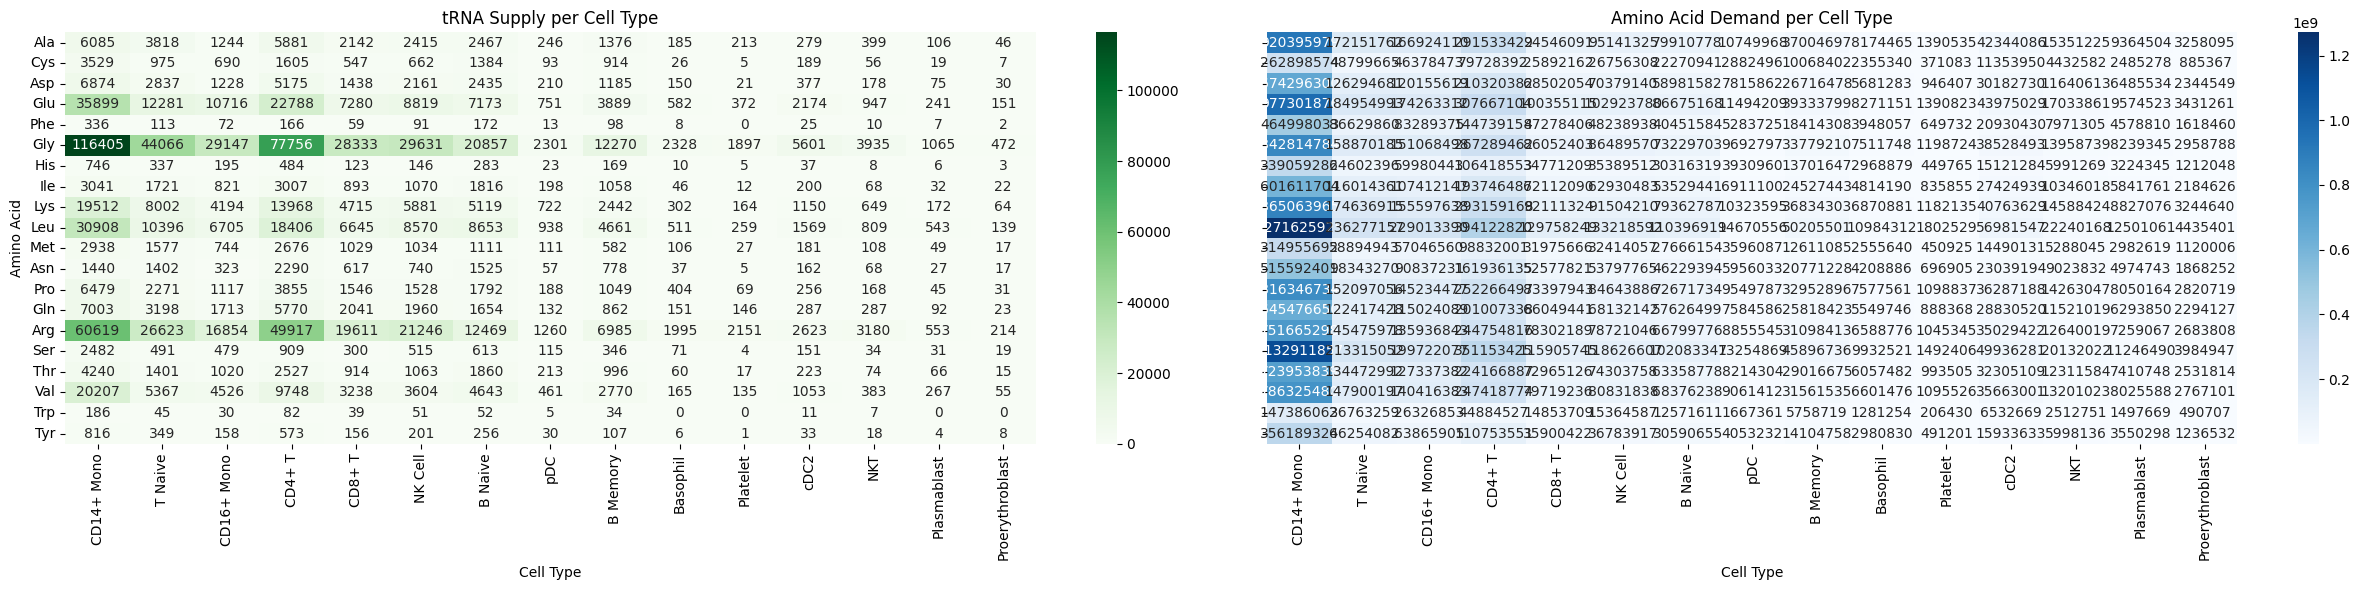

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Map 1-letter codes to 3-letter codes for demand
aa1_to_aa3 = {
    'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp',
    'C': 'Cys', 'Q': 'Gln', 'E': 'Glu', 'G': 'Gly',
    'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys',
    'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser',
    'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'
}

df_demand_named = df_demand.rename(index=aa1_to_aa3)

# Step 2: Align shared amino acids
shared_aas = df_demand_named.index.intersection(df_trna_aa_supply.index)
demand = df_demand_named.loc[shared_aas]
supply = df_trna_aa_supply.loc[shared_aas]

# Step 3: Plot supply and demand side-by-side
fig, axes = plt.subplots(1, 2, figsize=(25, 6), sharey=True)

# Heatmap 1: tRNA Supply
sns.heatmap(supply, ax=axes[0], cmap="Greens", annot=True, fmt=".0f")
axes[0].set_title("tRNA Supply per Cell Type")
axes[0].set_xlabel("Cell Type")
axes[0].set_ylabel("Amino Acid")

# Heatmap 2: AA Demand
sns.heatmap(demand, ax=axes[1], cmap="Blues", annot=True, fmt=".0f")
axes[1].set_title("Amino Acid Demand per Cell Type")
axes[1].set_xlabel("Cell Type")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


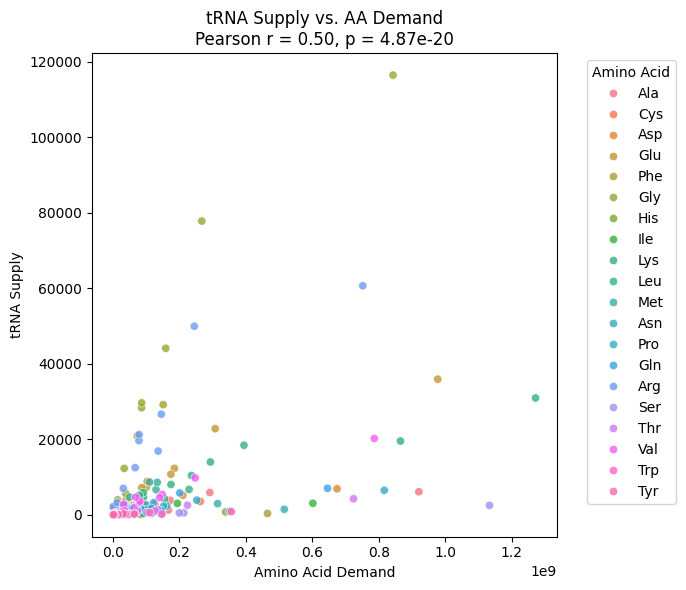

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Step 1: Align and flatten both tables
supply_flat = supply.stack().reset_index()
supply_flat.columns = ["amino_acid", "cell_type", "supply"]

demand_flat = demand.stack().reset_index()
demand_flat.columns = ["amino_acid", "cell_type", "demand"]

# Step 2: Merge supply and demand on (amino_acid, cell_type)
merged = pd.merge(supply_flat, demand_flat, on=["amino_acid", "cell_type"])

# Step 3: Scatter plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=merged, x="demand", y="supply", hue="amino_acid", alpha=0.8)

# Compute Pearson correlation
r, p = pearsonr(merged["demand"], merged["supply"])
plt.title(f"tRNA Supply vs. AA Demand\nPearson r = {r:.2f}, p = {p:.2e}")
plt.xlabel("Amino Acid Demand")
plt.ylabel("tRNA Supply")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Amino Acid")
plt.tight_layout()
plt.show()


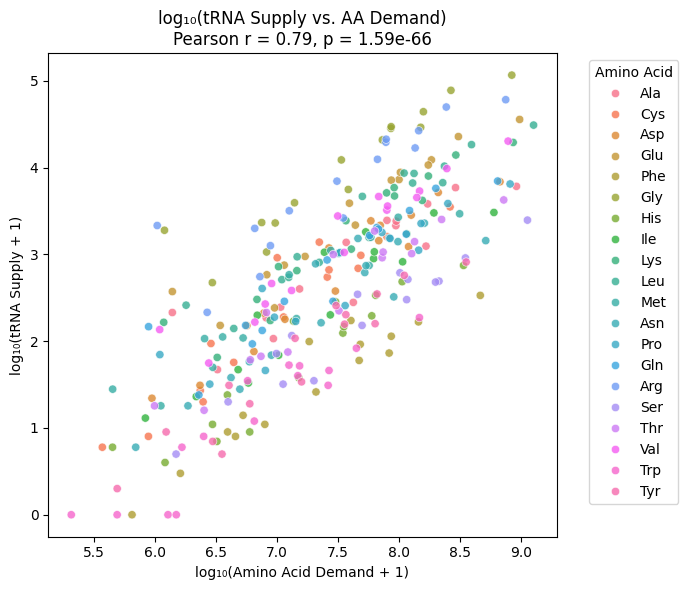

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Log-transform supply and demand (add pseudocount to avoid log(0))
merged["log_demand"] = np.log10(merged["demand"] + 1)
merged["log_supply"] = np.log10(merged["supply"] + 1)

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=merged,
    x="log_demand",
    y="log_supply",
    hue="amino_acid",
    alpha=0.8
)

# Correlation on log-transformed data
r_log, p_log = pearsonr(merged["log_demand"], merged["log_supply"])
plt.title(f"log₁₀(tRNA Supply vs. AA Demand)\nPearson r = {r_log:.2f}, p = {p_log:.2e}")
plt.xlabel("log₁₀(Amino Acid Demand + 1)")
plt.ylabel("log₁₀(tRNA Supply + 1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Amino Acid")
plt.tight_layout()
plt.show()


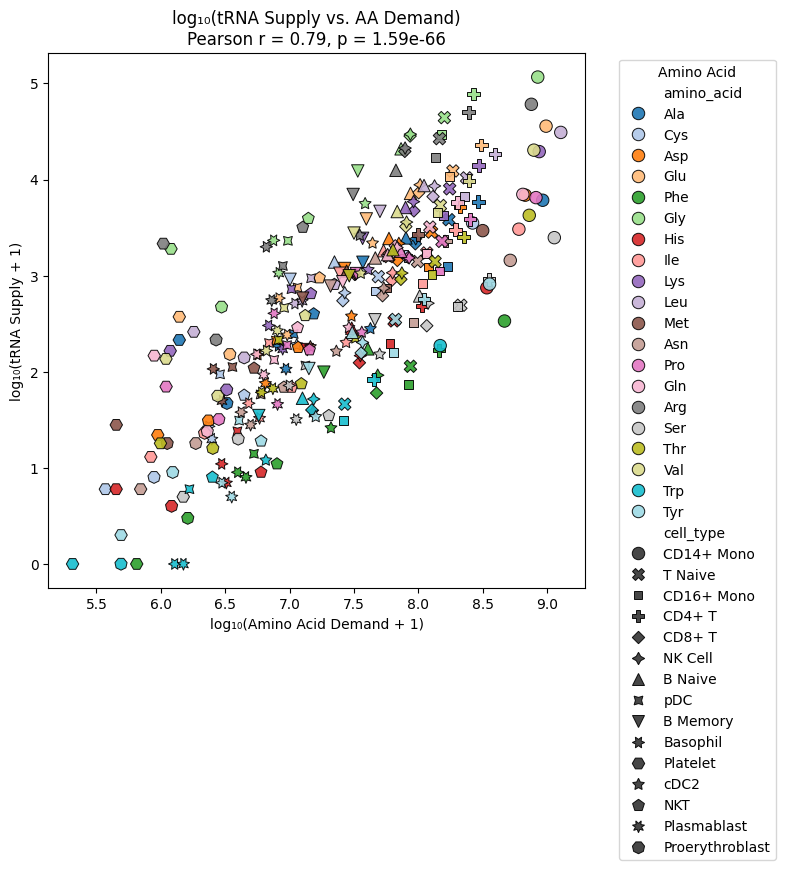

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Log-transform values
merged["log_demand"] = np.log10(merged["demand"] + 1)
merged["log_supply"] = np.log10(merged["supply"] + 1)

# Plot with marker shape by cell type
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=merged,
    x="log_demand",
    y="log_supply",
    hue="amino_acid",
    style="cell_type",        # Different marker shapes for each cell type
    palette="tab20",
    s=80,                     # Marker size
    alpha=0.9,
    edgecolor="black"
)

# Pearson correlation
r_log, p_log = pearsonr(merged["log_demand"], merged["log_supply"])
plt.title(f"log₁₀(tRNA Supply vs. AA Demand)\nPearson r = {r_log:.2f}, p = {p_log:.2e}")
plt.xlabel("log₁₀(Amino Acid Demand + 1)")
plt.ylabel("log₁₀(tRNA Supply + 1)")

# Improve legend spacing
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Amino Acid")
plt.tight_layout()
plt.show()


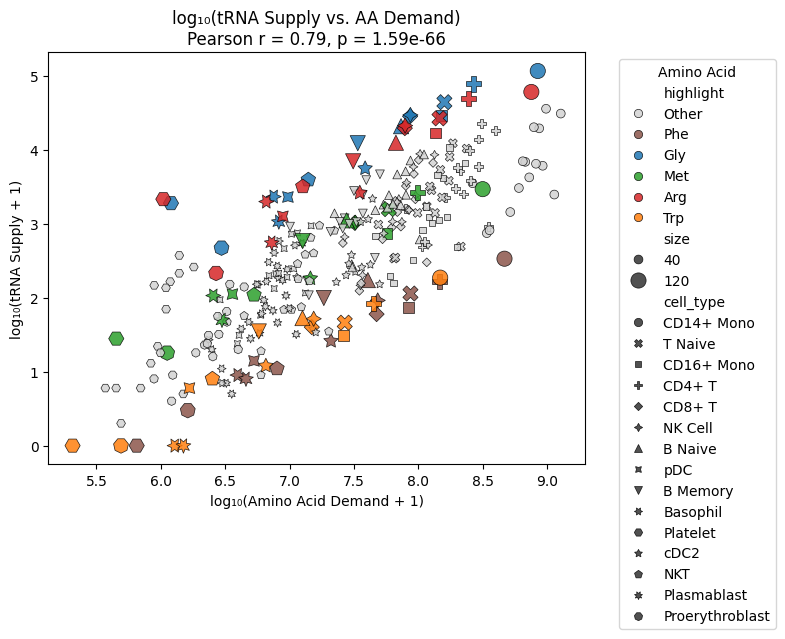

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Create highlight label
merged["highlight"] = merged["amino_acid"].apply(lambda x: x if x in ["Gly", "Arg", "Met", "Trp","Phe"] else "Other")

# Step 2: Create a color palette
custom_palette = {
    "Gly": "#1f77b4",    # blue
    "Arg": "#d62728",    # red
    "Met": "#2ca02c",    # red
    "Trp": "#ff7f0e",   # Orange
    "Phe": "#8c564b",   # Brown/earth tone
    "Other": "lightgray"
}

# Step 3: Optional — change size of highlighted points
merged["size"] = merged["highlight"].apply(lambda x: 120 if x in ["Gly", "Arg", "Met","Trp","Phe"] else 40)

# Step 4: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x="log_demand",
    y="log_supply",
    hue="highlight",
    style="cell_type",
    palette=custom_palette,
    size="size",
    sizes=(40, 120),
    alpha=0.85,
    edgecolor="black"
)

# Add correlation
from scipy.stats import pearsonr
r, p = pearsonr(merged["log_demand"], merged["log_supply"])
plt.title(f"log₁₀(tRNA Supply vs. AA Demand)\nPearson r = {r:.2f}, p = {p:.2e}")
plt.xlabel("log₁₀(Amino Acid Demand + 1)")
plt.ylabel("log₁₀(tRNA Supply + 1)")

# Legend settings
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Amino Acid")
plt.tight_layout()
plt.show()


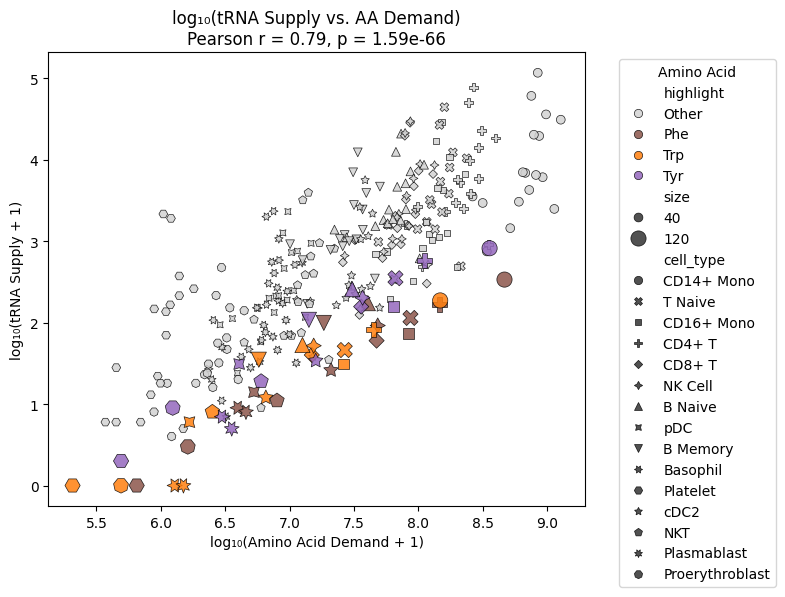

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Create highlight label
merged["highlight"] = merged["amino_acid"].apply(lambda x: x if x in ["Trp", "Tyr", "Phe"] else "Other")

# Step 2: Create a color palette
custom_palette = {
   "Trp": "#ff7f0e",   # Orange
    "Tyr": "#9467bd",   # Purple
    "Phe": "#8c564b",   # Brown/earth tone
    "Other": "lightgray"
}

# Step 3: Optional — change size of highlighted points
merged["size"] = merged["highlight"].apply(lambda x: 120 if x in ["Trp", "Tyr", "Phe"] else 40)

# Step 4: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x="log_demand",
    y="log_supply",
    hue="highlight",
    style="cell_type",
    palette=custom_palette,
    size="size",
    sizes=(40, 120),
    alpha=0.85,
    edgecolor="black"
)

# Add correlation
from scipy.stats import pearsonr
r, p = pearsonr(merged["log_demand"], merged["log_supply"])
plt.title(f"log₁₀(tRNA Supply vs. AA Demand)\nPearson r = {r:.2f}, p = {p:.2e}")
plt.xlabel("log₁₀(Amino Acid Demand + 1)")
plt.ylabel("log₁₀(tRNA Supply + 1)")

# Legend settings
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Amino Acid")
plt.tight_layout()
plt.show()


In [94]:
from collections import Counter
import pandas as pd
import numpy as np

# Pick amino acids to analyze
target_aas = ['W', 'Y', 'F']  # Trp, Tyr, Phe

# Get total counts per gene (across all cells or per cell type if desired)
counts_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
gene_names = adata.var_names
total_expr = counts_matrix.sum(axis=0).A1 if hasattr(counts_matrix, "A1") else np.ravel(counts_matrix.sum(axis=0))

# Store per-AA demand contributions per gene
aa_gene_demand = {aa: {} for aa in target_aas}

for gene, umi_count in zip(gene_names, total_expr):
    if umi_count > 0 and gene in gene_to_protein:
        seq = gene_to_protein[gene].upper()
        aa_counts = Counter(seq)
        for aa in target_aas:
            demand_contrib = aa_counts.get(aa, 0) * umi_count
            if demand_contrib > 0:
                aa_gene_demand[aa][gene] = demand_contrib

# Convert to sorted DataFrames for each AA
top_demand_genes = {
    aa: pd.Series(gene_dict).sort_values(ascending=False).head(20)
    for aa, gene_dict in aa_gene_demand.items()
}

# Display
for aa, df in top_demand_genes.items():
    print(f"\nTop genes driving {aa} demand ({aa} = {aa1_to_aa3.get(aa)}):")
    print(df)



Top genes driving W demand (W = Trp):
MT-CO1     4274560.0
VCAN       2711654.0
UTRN       1881982.0
LYZ        1795680.0
SIPA1L1    1626781.0
JARID2     1600776.0
MT-ND4     1545245.0
MT-CO3     1462176.0
EEF1A1     1458384.0
MED13L     1428096.0
RNF213     1415604.0
HERC1      1386620.0
FTH1       1383298.0
JMJD1C     1354866.0
BIRC6      1198124.0
B2M        1184056.0
SMCHD1     1133766.0
CHD1       1082978.0
HLA-A      1054262.0
MT-CYB     1017348.0
dtype: float64

Top genes driving Y demand (Y = Tyr):
SIPA1L1    6006576.0
MT-CO1     5877520.0
VCAN       5659104.0
B2M        3552168.0
SMCHD1     3527272.0
MYO9B      3376620.0
ACTB       3210165.0
RPS8       3177600.0
JARID2     2801358.0
FTH1       2766596.0
RNF213     2646564.0
EEF1A1     2430640.0
KMT2C      2368710.0
MED13L     2320656.0
BIRC6      2243296.0
CHD1       2207609.0
LYZ        2154816.0
FTL        2098621.0
RPL10      2069190.0
LYST       2022354.0
dtype: float64

Top genes driving F demand (F = Phe):
MT-CO1     10

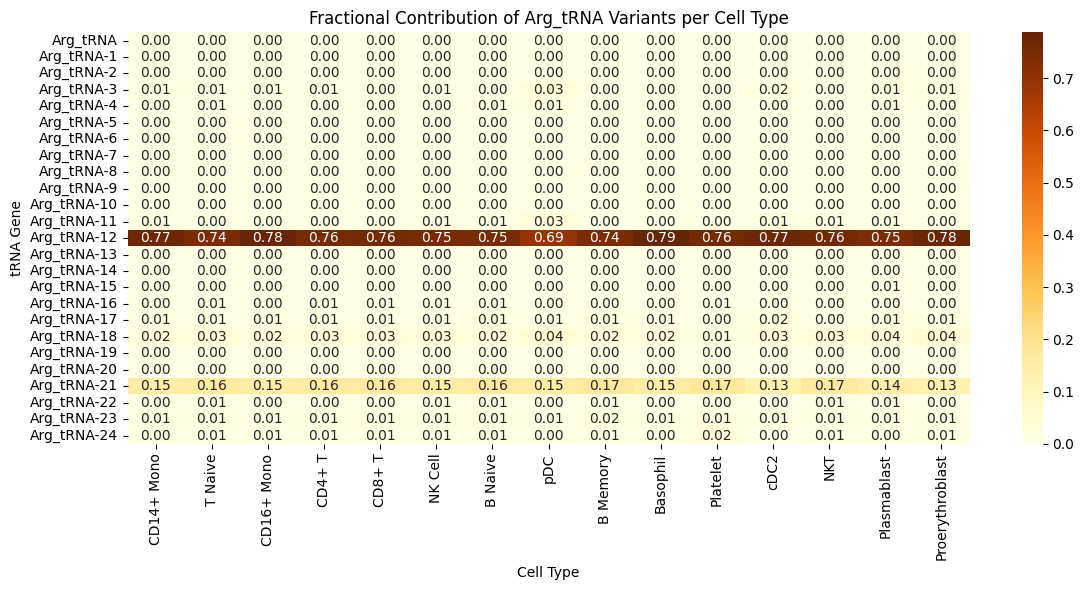

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for all Arg-specific tRNA genes
arg_trna_mask = adata.var_names.str.startswith("Arg_tRNA")
arg_trna_genes = adata.var_names[arg_trna_mask]

# Expression matrix (cells × genes)
counts = adata.layers["counts"] if "counts" in adata.layers else adata.X
arg_expr = counts[:, arg_trna_mask]

# Cell type info
cell_types = adata.obs["cell_type_lvl2"]
cell_type_groups = cell_types.unique()

# Initialize storage
arg_trna_by_celltype = pd.DataFrame(index=arg_trna_genes, columns=cell_type_groups)

# Sum expression per gene per cell type
for ct in cell_type_groups:
    mask = (cell_types == ct).values
    expr = arg_expr[mask, :].sum(axis=0)
    expr = np.array(expr).ravel()  # Flatten
    arg_trna_by_celltype[ct] = expr

# Normalize each column to sum to 1 → gives contribution fraction
arg_trna_frac = arg_trna_by_celltype.div(arg_trna_by_celltype.sum(axis=0), axis=1)

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(arg_trna_frac.astype(float), cmap="YlOrBr", annot=True, fmt=".2f")
plt.title("Fractional Contribution of Arg_tRNA Variants per Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("tRNA Gene")
plt.tight_layout()
plt.show()


In [98]:
# Case-insensitive search across column names
matches = [col for col in adata.obs.columns if "Arg_tRNA-12" in col.lower()]
print("Matching adata.obs columns:", matches)
for col in adata.obs.select_dtypes(include="object").columns:
    if adata.obs[col].str.contains("Arg_tRNA-12", case=False, na=False).any():
        print(f"'Arg_tRNA-12' found in values of column: {col}")


if "Arg_tRNA-12" in adata.var_names:
    gene_idx = list(adata.var_names).index("Arg_tRNA-12")
    expression = adata[:, gene_idx].X.toarray().flatten() if hasattr(adata.X, "toarray") else adata[:, gene_idx].X.flatten()
    adata.obs["Arg_tRNA-12_expr"] = expression
    print("Expression values now available in adata.obs['Arg_tRNA-12_expr']")


Matching adata.obs columns: []
Expression values now available in adata.obs['Arg_tRNA-12_expr']


In [103]:
gene_name = "Arg_tRNA-12"

if gene_name in adata.var_names:
    # Extract expression for that gene across all cells
    gene_idx = adata.var_names.get_loc(gene_name)
    gene_expr = adata[:, gene_idx].X
    gene_expr = gene_expr.toarray().flatten() if hasattr(gene_expr, "toarray") else np.ravel(gene_expr)
    
    # Optional: store in .obs
    adata.obs[f"{gene_name}_expr"] = gene_expr
else:
    print(f"{gene_name} not found in adata.var_names")


In [106]:
adata.var.loc[["Arg_tRNA-12"]].T  # Transposed for column-style view

,Arg_tRNA-12
gene_ids,35839
gene_id,35839
biotype,tRNA
n_cells,42422
gene_names,Arg_tRNA
n_cells_by_counts,42422
mean_counts,7.579297
pct_dropout_by_counts,37.374334
total_counts,513414.0
mt,False
